# File Information

__Author__: "Tan Hua Beng, G2203829L"

__Email__: "w220032@e.ntu.edus.g"

__Project__ = "IN6277 Assignment 2"

__Description__ = "Jupyter notebook containing the workings, notes, and code for IN6277 assignment 2. This assignment uses a dataset downloaded from Kaggle (https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset/). Two types of association rules algorithm - Apriori based on mlxtend python library and brute force python implementation taking reference from GitHub (https://github.com/Dhruvish97/Brute-Force-Rule-Mining), are applied and compared by analysing the time required for execution as the performance metric.

__License__ = "See README.md"

__Version__ = "1.0.0"


# Environment setup for assignment

A virual environment is created with running python version 3.11.5. Required python packages have been exported using the following commands and can be found within the project folder.

In [1]:
!pip list --format=freeze > requirements.txt
!conda list -e > conda_requirements.txt

# Import libraries

In [2]:
import os
import time
import math
import numpy as np
import pandas as pd
import itertools
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [3]:
G_DATASET_FILE = './dataset/Groceries_dataset.csv'
G_RESULTS_DIR = './results'

# Dataset for use with association rule algorithm

## Initial study to understand the dataset

In [4]:
# Create results directory
if not os.path.exists(G_RESULTS_DIR):
    os.makedirs(G_RESULTS_DIR)

# Check if dataset file exists, if not, raise error with message
if not os.path.exists(G_DATASET_FILE):
    raise FileNotFoundError('Dataset file does not exist!')

In [5]:
# Load dataset and read header information from the first row
data = pd.read_csv(G_DATASET_FILE, sep=',', header=0)

# Check the shape of the dataset
data.info()

# Check for missing values
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


Member_number      0
Date               0
itemDescription    0
dtype: int64

In [6]:
# Check unique values for each column
for col in data.columns:
    print(col, data[col].unique())


Member_number [1808 2552 2300 ... 3607 4587 2417]
Date ['21-07-2015' '05-01-2015' '19-09-2015' '12-12-2015' '01-02-2015'
 '14-02-2015' '08-05-2015' '23-12-2015' '20-03-2015' '12-02-2015'
 '24-02-2015' '14-04-2015' '03-09-2015' '30-03-2015' '03-05-2015'
 '02-09-2015' '03-08-2015' '07-07-2015' '08-09-2015' '12-11-2015'
 '18-09-2015' '30-11-2015' '17-07-2015' '12-06-2015' '13-02-2015'
 '14-01-2015' '08-03-2015' '27-01-2015' '22-10-2015' '26-10-2015'
 '08-10-2015' '03-10-2015' '11-04-2015' '21-02-2015' '29-09-2015'
 '09-01-2015' '03-04-2015' '20-04-2015' '04-08-2015' '19-07-2015'
 '06-10-2015' '16-10-2015' '06-06-2015' '26-09-2015' '15-08-2015'
 '21-05-2015' '25-08-2015' '11-03-2015' '05-06-2015' '28-07-2015'
 '05-09-2015' '19-06-2015' '11-10-2015' '16-06-2015' '20-01-2015'
 '15-02-2015' '13-04-2015' '07-02-2015' '02-03-2015' '14-03-2015'
 '22-12-2015' '01-07-2015' '03-11-2015' '12-04-2015' '05-05-2015'
 '12-05-2015' '08-07-2015' '21-09-2015' '10-12-2015' '30-09-2015'
 '31-01-2015' '13-12-

## Get frequency of items

In [7]:
# Count the frequency of each item
item_counts = data['itemDescription'].value_counts()

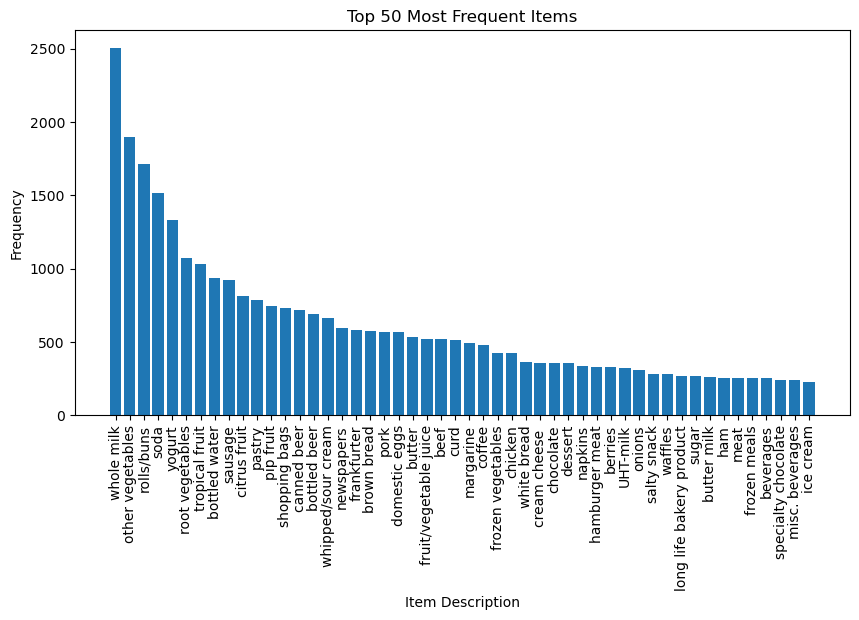

In [8]:
# Plot the top 50 most frequent items
plt.figure(figsize=(10, 5))
plt.bar(item_counts.index[:50], item_counts[:50])
plt.xticks(rotation=90)
plt.xlabel('Item Description')
plt.ylabel('Frequency')
plt.title('Top 50 Most Frequent Items')
plt.show()

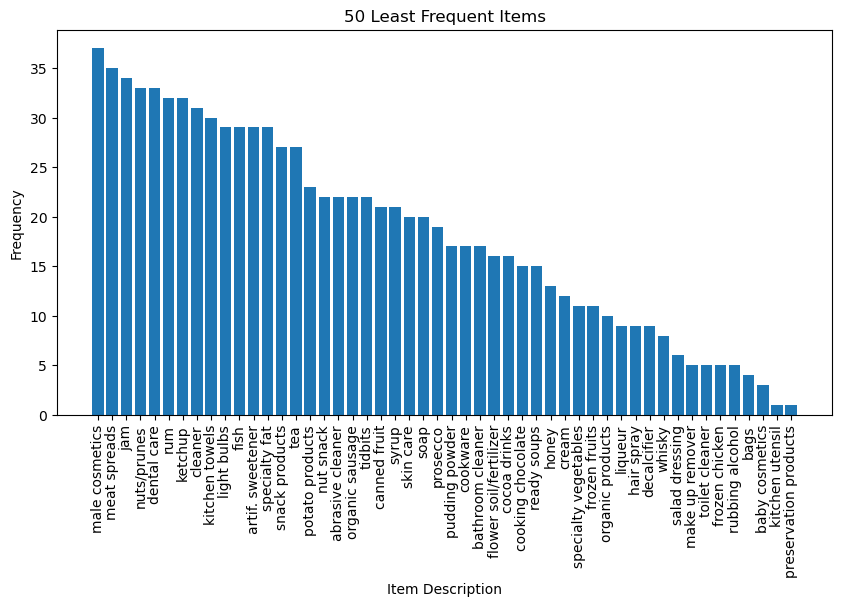

In [9]:
# Plot the 50 least frequent items
plt.figure(figsize=(10, 5))
plt.bar(item_counts.index[-50:], item_counts[-50:])
plt.xticks(rotation=90)
plt.xlabel('Item Description')
plt.ylabel('Frequency')
plt.title('50 Least Frequent Items')
plt.show()

In [10]:
# Show statistics of the item counts
item_counts.describe()

count     167.000000
mean      232.125749
std       363.442098
min         1.000000
25%        30.500000
50%        85.000000
75%       264.000000
max      2502.000000
Name: count, dtype: float64

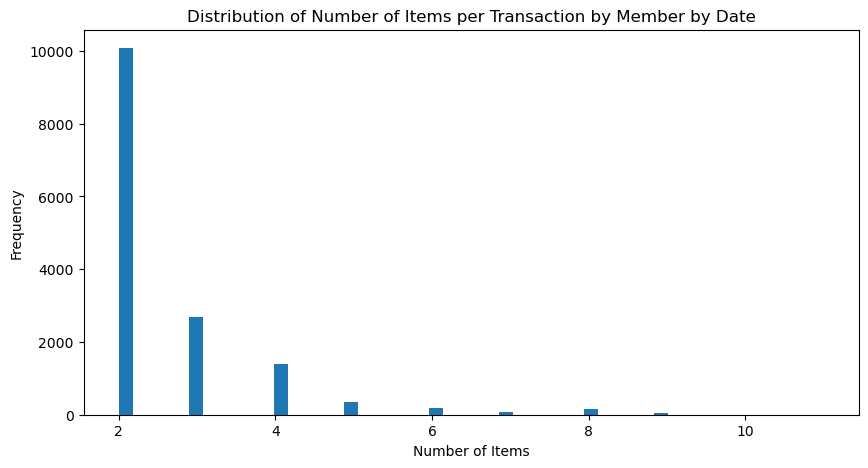

In [11]:
# Plot the distribution of the number of items per transaction by member by date
plt.figure(figsize=(10, 5))
plt.hist(data.groupby(['Member_number', 'Date']).size(), bins=50)
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Items per Transaction by Member by Date')
plt.show()

# Data pre-processing

## Drop records of items below the 75 percentile to reduce dimensionality

As we are focused on comparing the performance of Apriori and brute-force, and not the associations of items, the impact from deletion resulting in the lost of association or items does not affect the aim of this assignment.

In [12]:
# Get items less than 75 percentiles
items_low_freq = item_counts[item_counts < item_counts.quantile(0.75)]

# Delete records of items in the low frequency list
data_items_filtered = data[~data['itemDescription'].isin(items_low_freq.index)]

# Compare the shape of the original dataset and the filtered dataset
print(data.shape)
print(data_items_filtered.shape)

# Get the number of unique items
print('Number of unique items in original:', len(data['itemDescription'].unique()))
print('Number of unique items in filtered:', len(data_items_filtered['itemDescription'].unique()))


(38765, 3)
(28984, 3)
Number of unique items in original: 167
Number of unique items in filtered: 42


## Group records into transactions by date and member number

In [13]:
# Group by date and member number, and covert items to a list
data_transactions = data_items_filtered.groupby(['Member_number', 'Date'])['itemDescription'].apply(list).reset_index(name='items')

print(data_transactions.shape)

data_transactions.head()

(14278, 3)


,Member_number,Date,items
0,1000,15-03-2015,"[sausage, whole milk, yogurt]"
1,1000,24-06-2014,"[whole milk, pastry, salty snack]"
2,1000,24-07-2015,[canned beer]
3,1000,25-11-2015,[sausage]
4,1000,27-05-2015,[soda]


## One-hot encoding of the dataset organized into transactions

In [14]:
# Get unique items
data_items = data_transactions['items'].explode().unique()

print(data_items)
print(len(data_items))


['sausage' 'whole milk' 'yogurt' 'pastry' 'salty snack' 'canned beer'
 'soda' 'frankfurter' 'curd' 'rolls/buns' 'beef' 'white bread'
 'whipped/sour cream' 'frozen vegetables' 'other vegetables' 'butter'
 'tropical fruit' 'sugar' 'root vegetables' 'pip fruit' 'chocolate'
 'shopping bags' 'margarine' 'bottled water' 'chicken' 'bottled beer'
 'hamburger meat' 'dessert' 'domestic eggs' 'newspapers' 'coffee'
 'UHT-milk' 'citrus fruit' 'onions' 'brown bread' 'napkins'
 'fruit/vegetable juice' 'long life bakery product' 'berries'
 'cream cheese ' 'pork' 'waffles']
42


In [15]:
# Sort data_items by count so place higher frequency towards the left most columns, for higher support and confidence
data_items_sorted = data_transactions['items'].explode().value_counts().sort_values(ascending=False).index

print(data_items_sorted)

Index(['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt',
       'root vegetables', 'tropical fruit', 'bottled water', 'sausage',
       'citrus fruit', 'pastry', 'pip fruit', 'shopping bags', 'canned beer',
       'bottled beer', 'whipped/sour cream', 'newspapers', 'frankfurter',
       'brown bread', 'pork', 'domestic eggs', 'butter',
       'fruit/vegetable juice', 'beef', 'curd', 'margarine', 'coffee',
       'frozen vegetables', 'chicken', 'white bread', 'cream cheese ',
       'chocolate', 'dessert', 'napkins', 'berries', 'hamburger meat',
       'UHT-milk', 'onions', 'salty snack', 'waffles',
       'long life bakery product', 'sugar'],
      dtype='object', name='items')


In [16]:
# Create a one-hot encoded dataframe with items as columns
data_transactions_encoded = pd.DataFrame(columns=['Date', 'Member_number'] + list(data_items_sorted))

# Length of items
n_items = len(data_items_sorted)

for i in range(data_transactions.shape[0]):
    row = data_transactions.iloc[i]
    data_transactions_encoded.loc[i] = [row['Date'], row['Member_number']] + [False] * n_items
    for item in row['items']:
        data_transactions_encoded.loc[i, item] = True


In [17]:
# Display the encoded dataframe
data_transactions_encoded.head()

,Date,Member_number,whole milk,other vegetables,rolls/buns,soda,yogurt,root vegetables,tropical fruit,bottled water,...,dessert,napkins,berries,hamburger meat,UHT-milk,onions,salty snack,waffles,long life bakery product,sugar
0,15-03-2015,1000,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,24-06-2014,1000,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,24-07-2015,1000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,25-11-2015,1000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,27-05-2015,1000,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Develop/ test association rule algorithm

## Test apriori algorithm on subset of dataset

In [18]:
# Function to execute Apriori algorithm
def execute_apriori(data, min_support, min_confidence):

    # Capture time to execute apriori algorithm
    start_time = time.time()

    # Apply apriori algorithm to find frequent itemsets on subset of data by min support
    frequent_itemsets = apriori(data_transactions_encoded.iloc[:n_transactions, 2:n_items+2], min_support=0.01, use_colnames=True)

    time_frequent_itemsets = time.time() - start_time

    start_time = time.time()

    # Generate association rules from frequent itemsets
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.01)

    time_association_rules = time.time() - start_time

    # Print time to execute apriori algorithm
    print('Time to execute apriori algorithm:', time_frequent_itemsets + time_association_rules)

    return frequent_itemsets, rules, time_frequent_itemsets, time_association_rules

# Set number of transactions and items to include in the subset
n_transactions = 10
n_items = 4

# Execute apriori algorithm
test_apriori_frequent_itemsets, test_apriori_rules, test_apriori_time_frequent_itemsets, test_apriori_time_association_rules = execute_apriori(data_transactions_encoded, min_support=0.01, min_confidence=0.01)


Time to execute apriori algorithm: 0.008664846420288086


In [19]:
# Display frequent itemsets
test_apriori_frequent_itemsets.head()

,support,itemsets
0,0.4,(whole milk)
1,0.1,(rolls/buns)
2,0.3,(soda)
3,0.1,"(whole milk, rolls/buns)"
4,0.1,"(whole milk, soda)"


In [20]:
# Display association rules
test_apriori_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(whole milk),(rolls/buns),0.4,0.1,0.1,0.250000,2.500000,0.06,1.200000,1.000000
1,(rolls/buns),(whole milk),0.1,0.4,0.1,1.000000,2.500000,0.06,inf,0.666667
2,(whole milk),(soda),0.4,0.3,0.1,0.250000,0.833333,-0.02,0.933333,-0.250000
3,(soda),(whole milk),0.3,0.4,0.1,0.333333,0.833333,-0.02,0.900000,-0.222222


## Function to perform association rule by brute-force

The brute-force output is attempting to match the output of apriori algorithm output from mlxtend so as to simulate similar computations load with formulas in association rules taken from Bismi, I. (2023, April 10). How to perform Market Basket Analysis using Apriori Algorithm and Association Rules. Medium. https://medium.com/@iqra.bismi/how-to-perform-market-basket-analysis-using-apriori-algorithm-and-association-rules-3f6ba61d6e4b
.


In [21]:
# Function to generate frequent itemsets
def generate_frequent_itemsets(data, min_support=0.01):
    # Initialize variables for frequent and complete itemsets
    frequent_itemsets = pd.DataFrame(columns=['support', 'itemsets'])
    all_itemsets = []

    # Compute min support count
    min_support_count = min_support * data.shape[0]

    # Get unique items
    items = data.columns

    for i in range(1, len(items) + 1):
        for itemset in itertools.combinations(items, i):
            # Compute support
            support = data[list(itemset)].all(axis=1).sum()
            if support >= min_support_count:
                frequent_itemsets.loc[len(frequent_itemsets)] = [support / data.shape[0], itemset]
            all_itemsets.append(itemset)
    
    return frequent_itemsets, all_itemsets

# Function to perform association rule by brute force
def assocation_rules_brute_force(data, min_support=0.01, min_confidence=None):

    # Initialize association rules
    rules = pd.DataFrame(columns=['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift', 'leverage', 'conviction', 'zhang'])

    # Compute time to execute frequent itemsets and association rules
    start_time = time.time()

    # Compute frequent itemsets
    frequent_itemsets, all_itemsets = generate_frequent_itemsets(data, min_support)

    time_frequent_itemsets = time.time() - start_time

    start_time = time.time()

    # Compute association rules
    for i in range(frequent_itemsets.shape[0]):
        frequent_itemset = frequent_itemsets.iloc[i]
        for j in range(1, len(frequent_itemset['itemsets'])):
            # Generate possible parent itemsets
            for antecedent in itertools.combinations(frequent_itemset['itemsets'], j):
                antecedent = set(antecedent)
                consequent = set(frequent_itemset['itemsets']) - antecedent
                antecedent_support = data[list(antecedent)].all(axis=1).sum() / data.shape[0]
                consequent_support = data[list(consequent)].all(axis=1).sum() / data.shape[0]
                support = frequent_itemset['support']
                if antecedent_support != 0 and not np.isnan(antecedent_support):
                    confidence = support / antecedent_support
                else:
                    # set confidence to infinity
                    confidence = np.inf
                if consequent_support != 0 and not np.isnan(consequent_support) and confidence != np.inf:
                    lift = confidence / consequent_support
                else:
                    # set lift to infinity
                    lift = np.inf
                leverage = support - antecedent_support * consequent_support
                if confidence != 1 and not np.isnan(confidence) and not np.isinf(confidence):
                    conviction = (1 - consequent_support) / (1 - confidence)
                else:
                    conviction = 0
                if antecedent_support * consequent_support != 0:
                    zhangs_metric = (support - antecedent_support * consequent_support) / (1 - antecedent_support * consequent_support)
                else:
                    zhangs_metric = 0
                if min_confidence is None:
                    rules.loc[len(rules)] = [antecedent, consequent, antecedent_support, consequent_support, support, confidence, lift, leverage, conviction, zhangs_metric]
                else:
                    if not np.isnan(confidence) and not np.isinf(confidence) and confidence >= min_confidence:
                        rules.loc[len(rules)] = [antecedent, consequent, antecedent_support, consequent_support, support, confidence, lift, leverage, conviction, zhangs_metric]
                    
    time_association_rules = time.time() - start_time

    # Print time to execute frequent itemsets and association rules
    print('Time to execute frequent itemsets and association rules:', time_frequent_itemsets + time_association_rules)

    return frequent_itemsets, rules, time_frequent_itemsets, time_association_rules, all_itemsets


## Test brute force association rule on subset of dataset

In [22]:
# Set number of transactions and items to include in the subset
n_transactions = 10
n_items = 4

# Apply brute force algorithm to find frequent itemsets and association rules
test_bruteforce_frequent_itemsets, test_bruteforce_rules, test_bruteforce_time_frequent_itemsets, test_bruteforce_time_association_rules, _ = assocation_rules_brute_force(data_transactions_encoded.iloc[:n_transactions, 2:n_items+2], 
    min_support=0.01, min_confidence=0.01)

Time to execute frequent itemsets and association rules: 0.029989004135131836


In [23]:
# Display frequent itemsets
test_bruteforce_frequent_itemsets.head()

,support,itemsets
0,0.4,"(whole milk,)"
1,0.1,"(rolls/buns,)"
2,0.3,"(soda,)"
3,0.1,"(whole milk, rolls/buns)"
4,0.1,"(whole milk, soda)"


In [24]:
# Display association rules
test_bruteforce_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
0,{whole milk},{rolls/buns},0.4,0.1,0.1,0.250000,2.500000,0.06,1.200000,0.062500
1,{rolls/buns},{whole milk},0.1,0.4,0.1,1.000000,2.500000,0.06,0.000000,0.062500
2,{whole milk},{soda},0.4,0.3,0.1,0.250000,0.833333,-0.02,0.933333,-0.022727
3,{soda},{whole milk},0.3,0.4,0.1,0.333333,0.833333,-0.02,0.900000,-0.022727


## Check correctness of the brute force algorithm

Combination is used as order for items in the basket is not required unlike the position of letters in words (permutation).

In [25]:
# Formula to compute the number of possible itemsets combinations selecting r items from n items
def nCr(n, r):
    result = math.factorial(n) / (math.factorial(r) * math.factorial(n - r))
    print("r: ", r, " n: ", n, " result: ", result)
    return result

# Formula to compute all possible itemsets combinations
def nCr_all(n):
    return sum([nCr(n, r+1) for r in range(n)])

# Compute the number of possible itemsets combinations
print("Number of possible itemsets combinations by calculation: ", nCr_all(n_items))

r:  1  n:  4  result:  4.0
r:  2  n:  4  result:  6.0
r:  3  n:  4  result:  4.0
r:  4  n:  4  result:  1.0
Number of possible itemsets combinations by calculation:  15.0


In [26]:
# Check the combination of the items has no duplicates and is equal to the number of possible itemsets
temp_freq_itemsets, temp_full_itemsets = generate_frequent_itemsets(data_transactions_encoded.iloc[:n_transactions, 2:n_items+2], min_support=0.01)

print("Length of combinations in full: ", len(temp_full_itemsets))
print("Frequency count of each unique combination: ", pd.Series(temp_full_itemsets).value_counts())

Length of combinations in full:  15
Frequency count of each unique combination:  (whole milk,)                                       1
(other vegetables,)                                 1
(rolls/buns,)                                       1
(soda,)                                             1
(whole milk, other vegetables)                      1
(whole milk, rolls/buns)                            1
(whole milk, soda)                                  1
(other vegetables, rolls/buns)                      1
(other vegetables, soda)                            1
(rolls/buns, soda)                                  1
(whole milk, other vegetables, rolls/buns)          1
(whole milk, other vegetables, soda)                1
(whole milk, rolls/buns, soda)                      1
(other vegetables, rolls/buns, soda)                1
(whole milk, other vegetables, rolls/buns, soda)    1
Name: count, dtype: int64


In [27]:
# Compare the frequent itemsets generated by brute force and apriori algorithm
print("Apriori frequent itemsets: ")
print(test_apriori_frequent_itemsets)
print("\n")
print("Brute force frequent itemsets: ")
print(test_bruteforce_frequent_itemsets)

Apriori frequent itemsets: 
   support                  itemsets
0      0.4              (whole milk)
1      0.1              (rolls/buns)
2      0.3                    (soda)
3      0.1  (whole milk, rolls/buns)
4      0.1        (whole milk, soda)


Brute force frequent itemsets: 
   support                  itemsets
0      0.4             (whole milk,)
1      0.1             (rolls/buns,)
2      0.3                   (soda,)
3      0.1  (whole milk, rolls/buns)
4      0.1        (whole milk, soda)


In [28]:
# Compare the association rules generated by brute force and apriori algorithm
print("Apriori association rules: ")
print(test_apriori_rules)
print("\n")
print("Brute force association rules: ")
print(test_bruteforce_rules)

Apriori association rules: 
    antecedents   consequents  antecedent support  consequent support  \
0  (whole milk)  (rolls/buns)                 0.4                 0.1   
1  (rolls/buns)  (whole milk)                 0.1                 0.4   
2  (whole milk)        (soda)                 0.4                 0.3   
3        (soda)  (whole milk)                 0.3                 0.4   

   support  confidence      lift  leverage  conviction  zhangs_metric  
0      0.1    0.250000  2.500000      0.06    1.200000       1.000000  
1      0.1    1.000000  2.500000      0.06         inf       0.666667  
2      0.1    0.250000  0.833333     -0.02    0.933333      -0.250000  
3      0.1    0.333333  0.833333     -0.02    0.900000      -0.222222  


Brute force association rules: 
    antecedents   consequents  antecedent support  consequent support  \
0  {whole milk}  {rolls/buns}                 0.4                 0.1   
1  {rolls/buns}  {whole milk}                 0.1                 

The possible combinations processed in generate_frequent_itemsets matches the mathematical calculation of all possible combinations as shown above. No repetition of the combination was generated.

The results from mlxtend Apriori and brute-force algorithm are identical in terms of frequent itemset and association rules identified.

This high level verification provides a confidence of the correct implementation.

# Perform comparison between Apriori and brute-force association rules

## Define some constants to use for comparison

In [29]:
# Create list of transactions count to use for each iteration
n_iterations = 8
n_transactions_list = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
n_items_list = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
min_support = 0.01
min_confidence = 0.01

# Initialize result variable to store time to execute frequent itemsets, association rules, and total time between apriori and brute force
result_apriori = []
result_brute_force = []

## Run and collect timing metrics for Apriori with increasing transactions/ items (based on configured values above) over iterations

In [30]:
# Iterate through each combination of transactions and items
for i in range(n_iterations):
    n_transactions = n_transactions_list[i]
    n_items = n_items_list[i]
    print('Transactions:', n_transactions, 'Items:', n_items)
    # Execute apriori algorithm
    frequent_itemsets, rules, time_frequent_itemsets, time_association_rules = execute_apriori(data_transactions_encoded.iloc[:n_transactions, 2:n_items+2], 
        min_support=min_support, min_confidence=min_confidence)
    result_apriori.append([time_frequent_itemsets, time_association_rules, time_frequent_itemsets + time_association_rules])

Transactions: 10 Items: 4
Time to execute apriori algorithm: 0.0057642459869384766
Transactions: 10 Items: 5
Time to execute apriori algorithm: 0.004873991012573242
Transactions: 10 Items: 6
Time to execute apriori algorithm: 0.004778146743774414
Transactions: 10 Items: 7
Time to execute apriori algorithm: 0.006228923797607422
Transactions: 10 Items: 8
Time to execute apriori algorithm: 0.004378318786621094
Transactions: 10 Items: 9
Time to execute apriori algorithm: 0.005626678466796875
Transactions: 10 Items: 10
Time to execute apriori algorithm: 0.006961822509765625
Transactions: 10 Items: 11
Time to execute apriori algorithm: 0.005482912063598633


## Run and collect timing metrics for brute-force with increasing transactions over iterations

In [31]:
# Iterate through each combination of transactions and items
for i in range(n_iterations):
    n_transactions = n_transactions_list[i]
    n_items = n_items_list[i]
    print('Transactions:', n_transactions, 'Items:', n_items)
    # Execute brute force algorithm
    frequent_itemsets, rules, time_frequent_itemsets, time_association_rules, _ = assocation_rules_brute_force(data_transactions_encoded.iloc[:n_transactions, 2:n_items+2], 
        min_support=min_support, min_confidence=min_confidence)
    result_brute_force.append([time_frequent_itemsets, time_association_rules, time_frequent_itemsets + time_association_rules])

Transactions: 10 Items: 4
Time to execute frequent itemsets and association rules: 0.02506113052368164
Transactions: 10 Items: 5
Time to execute frequent itemsets and association rules: 0.04364299774169922
Transactions: 10 Items: 6
Time to execute frequent itemsets and association rules: 0.06052136421203613
Transactions: 10 Items: 7
Time to execute frequent itemsets and association rules: 0.10494303703308105
Transactions: 10 Items: 8
Time to execute frequent itemsets and association rules: 0.18473196029663086
Transactions: 10 Items: 9


Time to execute frequent itemsets and association rules: 0.4457380771636963
Transactions: 10 Items: 10
Time to execute frequent itemsets and association rules: 0.6864199638366699
Transactions: 10 Items: 11
Time to execute frequent itemsets and association rules: 1.3654241561889648


## Compare and plot results for comparison

In [32]:
# Convert result to dataframe
result_apriori = pd.DataFrame(result_apriori, columns=['time_frequent_itemsets', 'time_association_rules', 'time_total'])
result_brute_force = pd.DataFrame(result_brute_force, columns=['time_frequent_itemsets', 'time_association_rules', 'time_total'])


In [33]:
# Display result for Apriori algorithm
result_apriori

# Save result for Apriori algorithm
result_apriori.to_csv(os.path.join(G_RESULTS_DIR, 'result_apriori.csv'), index=False)

In [34]:
# Display result for brute force algorithm
result_brute_force

# Save result for brute force algorithm
result_brute_force.to_csv(os.path.join(G_RESULTS_DIR, 'result_brute_force.csv'), index=False)

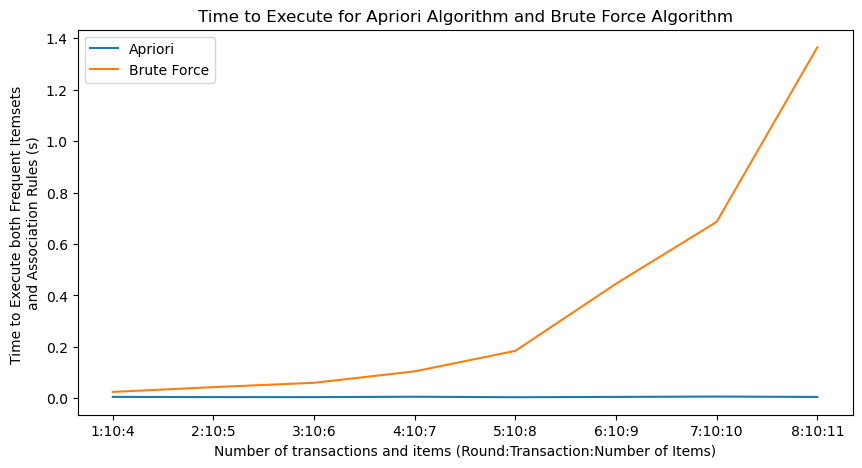

In [53]:
# Plot the time to execute for Apriori algorithm and brute force algorithm
plt.figure(figsize=(10, 5))
plt.plot(result_apriori['time_total'], label='Apriori')
plt.plot(result_brute_force['time_total'], label='Brute Force')

# Map the x-axis to round:transactions:items
plt.xticks(range(n_iterations), [str(i+1) + ":" + str(n_transactions_list[i]) + ':' + str(n_items_list[i]) for i in range(n_iterations)])
plt.xlabel('Number of transactions and items (Round:Transaction:Number of Items)')
plt.ylabel('Time to Execute both Frequent Itemsets \nand Association Rules (s)')
plt.title('Time to Execute for Apriori Algorithm and Brute Force Algorithm')
plt.legend()

In [80]:
# Generate table for comparing the time to execute for Apriori algorithm and brute force algorithm
results_table_column = [('Round ' + str(i+1)) for i in range(n_iterations)]
results_table = pd.DataFrame(columns=results_table_column)
results_table.loc['Transactions'] = n_transactions_list[:n_iterations]
results_table.loc['Items'] = n_items_list[:n_iterations]
results_table.loc['Itemset Combinations'] = [nCr_all(n_items_list[i]) for i in range(n_iterations)]
results_table.loc['Apriori'] = result_apriori['time_total'].values
results_table.loc['Brute Force'] = result_brute_force['time_total'].values

# Save results table as csv
results_table.to_csv(os.path.join(G_RESULTS_DIR, 'results_table.csv'))

r:  1  n:  4  result:  4.0
r:  2  n:  4  result:  6.0
r:  3  n:  4  result:  4.0
r:  4  n:  4  result:  1.0
r:  1  n:  5  result:  5.0
r:  2  n:  5  result:  10.0
r:  3  n:  5  result:  10.0
r:  4  n:  5  result:  5.0
r:  5  n:  5  result:  1.0
r:  1  n:  6  result:  6.0
r:  2  n:  6  result:  15.0
r:  3  n:  6  result:  20.0
r:  4  n:  6  result:  15.0
r:  5  n:  6  result:  6.0
r:  6  n:  6  result:  1.0
r:  1  n:  7  result:  7.0
r:  2  n:  7  result:  21.0
r:  3  n:  7  result:  35.0
r:  4  n:  7  result:  35.0
r:  5  n:  7  result:  21.0
r:  6  n:  7  result:  7.0
r:  7  n:  7  result:  1.0
r:  1  n:  8  result:  8.0
r:  2  n:  8  result:  28.0
r:  3  n:  8  result:  56.0
r:  4  n:  8  result:  70.0
r:  5  n:  8  result:  56.0
r:  6  n:  8  result:  28.0
r:  7  n:  8  result:  8.0
r:  8  n:  8  result:  1.0
r:  1  n:  9  result:  9.0
r:  2  n:  9  result:  36.0
r:  3  n:  9  result:  84.0
r:  4  n:  9  result:  126.0
r:  5  n:  9  result:  126.0
r:  6  n:  9  result:  84.0
r:  7  

In [79]:
results_table

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8
Transactions,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
Items,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000
Itemset Combinations,15.000000,31.000000,63.000000,127.000000,255.000000,511.000000,1023.000000,2047.000000
Apriori,0.005764,0.004874,0.004778,0.006229,0.004378,0.005627,0.006962,0.005483
Brute Force,0.025061,0.043643,0.060521,0.104943,0.184732,0.445738,0.686420,1.365424


# Compute time constant for brute force algorithm

In [62]:
# Compute and record the possible combinations and execution time, to derive the relationship between the number of possible combinations and execution time
result_brute_force_all = []
n_iterations_all = 20

# Iterate through each combination of transactions and items
for i in range(n_iterations_all):
    # Execute brute force algorithm
    frequent_itemsets, rules, time_frequent_itemsets, time_association_rules, all_itemsets = assocation_rules_brute_force(data_transactions_encoded.iloc[:10, 2:(i+1)+2])
    result_brute_force_all.append([len(all_itemsets), time_frequent_itemsets + time_association_rules, (time_frequent_itemsets + time_association_rules)/ len(all_itemsets)])


Time to execute frequent itemsets and association rules: 0.003058195114135742
Time to execute frequent itemsets and association rules: 0.0034623146057128906
Time to execute frequent itemsets and association rules: 0.015823841094970703
Time to execute frequent itemsets and association rules: 0.04420185089111328
Time to execute frequent itemsets and association rules: 0.08601498603820801
Time to execute frequent itemsets and association rules: 0.09813594818115234
Time to execute frequent itemsets and association rules: 0.11103391647338867
Time to execute frequent itemsets and association rules: 0.13625407218933105
Time to execute frequent itemsets and association rules: 0.4226830005645752
Time to execute frequent itemsets and association rules: 0.5878770351409912
Time to execute frequent itemsets and association rules: 1.1519007682800293
Time to execute frequent itemsets and association rules: 2.1701810359954834
Time to execute frequent itemsets and association rules: 4.465346813201904
T

In [63]:
# Convert result to dataframe
result_brute_force_all = pd.DataFrame(result_brute_force_all, columns=['n_combinations', 'time_total', 'time_per_combination'])
# Save result
result_brute_force_all.to_csv(os.path.join(G_RESULTS_DIR, 'result_brute_force_all.csv'), index=False)
# Display result
result_brute_force_all

,n_combinations,time_total,time_per_combination
0,1,0.003058,0.003058
1,3,0.003462,0.001154
2,7,0.015824,0.002261
3,15,0.044202,0.002947
4,31,0.086015,0.002775
5,63,0.098136,0.001558
6,127,0.111034,0.000874
7,255,0.136254,0.000534
8,511,0.422683,0.000827
9,1023,0.587877,0.000575


In [67]:
# Statistics of the time per combination
time_constant_per_combination = result_brute_force_all['time_per_combination'].mean()
print('Time per combination:', time_constant_per_combination)
result_brute_force_all['time_per_combination'].describe()


Time per combination: 0.0011478944215441143


count    20.000000
mean      0.001148
std       0.000874
min       0.000530
25%       0.000572
50%       0.000758
75%       0.001255
max       0.003058
Name: time_per_combination, dtype: float64

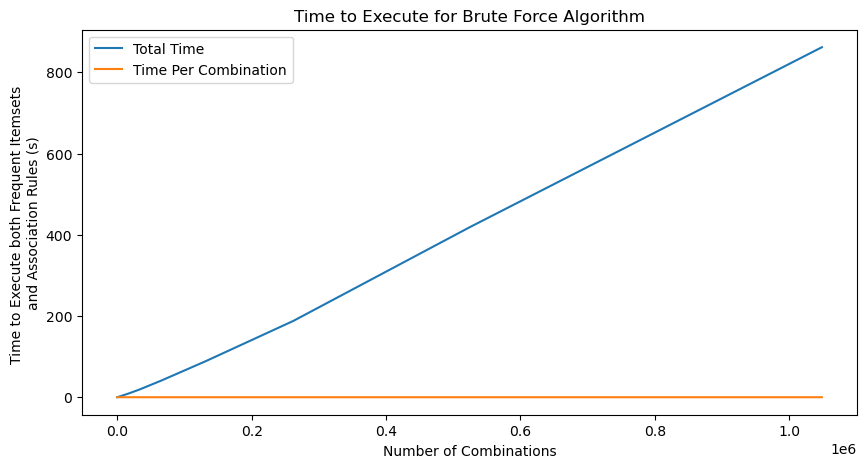

In [68]:
# Generate a plot to show the relationship between the number of possible combinations and execution time with time per combination
plt.figure(figsize=(10, 5))
plt.plot(result_brute_force_all['n_combinations'], result_brute_force_all['time_total'], label='Total Time')
plt.plot(result_brute_force_all['n_combinations'], result_brute_force_all['time_per_combination'], label='Time Per Combination')
plt.xlabel('Number of Combinations')
plt.ylabel('Time to Execute both Frequent Itemsets \nand Association Rules (s)')
plt.title('Time to Execute for Brute Force Algorithm')
plt.legend()

# Derive formula for estimate brute force execution time

In [71]:
# Function to estimate the time to execute unique  for a given number of items
def estimate_time(n_items, time_constant=time_constant_per_combination):
    # Compute the number of possible combinations
    n_combinations = nCr_all(n_items)
    # Estimate the time to execute
    time_total = time_constant * n_combinations
    return n_combinations, time_total

# Estimate the time to execute for 100 items
print(estimate_time(50))

r:  1  n:  50  result:  50.0
r:  2  n:  50  result:  1225.0
r:  3  n:  50  result:  19600.0
r:  4  n:  50  result:  230300.0
r:  5  n:  50  result:  2118760.0
r:  6  n:  50  result:  15890700.0
r:  7  n:  50  result:  99884400.0
r:  8  n:  50  result:  536878650.0
r:  9  n:  50  result:  2505433700.0
r:  10  n:  50  result:  10272278170.0
r:  11  n:  50  result:  37353738800.0
r:  12  n:  50  result:  121399651100.0
r:  13  n:  50  result:  354860518600.0
r:  14  n:  50  result:  937845656300.0
r:  15  n:  50  result:  2250829575120.0
r:  16  n:  50  result:  4923689695575.0
r:  17  n:  50  result:  9847379391150.0
r:  18  n:  50  result:  18053528883775.0
r:  19  n:  50  result:  30405943383200.0
r:  20  n:  50  result:  47129212243960.0
r:  21  n:  50  result:  67327446062800.0
r:  22  n:  50  result:  88749815264600.0
r:  23  n:  50  result:  108043253365600.0
r:  24  n:  50  result:  121548660036300.0
r:  25  n:  50  result:  126410606437752.0
r:  26  n:  50  result:  1215486600363

# Results

In this comparison between mlxtend Apriori and implemented brute-force algorithm, dataset is pre-processed to keep items with higher frequency (75 percentile) for the purpose of this analysis as the support and confidence values for low frequency items can be difficult/ sensitive to implementation differences for observation.

A high level verification of the implemented brute-force algorithm was conducted by checking the total number of combinations processed against the mathematical calcuation of: $$\sum_{r=1}^n n! / (r! * (n-r)!)$$
where n is number of items, r is selection size

In addition, the results of frequent itemsets and association rules from both mlxtend Apriori and implemented brute-force algorithm were compared, and found to be identical, except for the precision differences in the Zhang's metric. The number of metrics computed in brute-force is kept similar to Apriori to keep computational scope similar so as to provide a more identical workload comparison.

The number of transactions is kept as a constant while only varying the number of items in execution and recording of both algorithms, with the number of items ranging from 4 to 11 over 8 iterations. Minimum support and confidence are also set to constant 0.01 for the execution time analysis.

From observation of the graph plotted (number of items to execution time), the time for brute-force algorithm execution increases (positive related) as compared to Apriori which remains relatively constant.

To find the estimated time constant value (C) for brute-force, 20 iterations of brute-force algorithm is performed with itemset size ranging from 1 to 20. The average execution time per combination is computed as follows: $$C = (t_f + t_a)/ \sum_{r=1}^n n! / (r! * (n-r)!)$$
where n is number of items, r is selection size, t<sub>f</sub> is execution time for frequent itemsets, t<sub>a</sub> is execution time for association rules

C is calculated at 0.0011478944215441143 seconds from the procedure above.
> The time constant estimation is performed on a Macbook pro with 2.8 GHz Quad-Core Intel Core i7 CPU and 16 GB 2133 MHz LPDDR3 Memory.

The estimated time E for n items is therefore computed with: $$E = C * \sum_{r=1}^n n! / (r! * (n-r)!) $$

For 50 items, the time estimated for brute force algorithm (execution of frequent itemsets and high confidence association rules) is approximately 1.13 quadrillion (1,125,899,906,842,623) combinations requiring about approximately 40,881 years (1,292,414,222,281.6848 seconds).


# References

1. Bismi, I. (2023, April 10). How to perform Market Basket Analysis using Apriori Algorithm and Association Rules. Medium. https://medium.com/@iqra.bismi/how-to-perform-market-basket-analysis-using-apriori-algorithm-and-association-rules-3f6ba61d6e4b
2. Mehta, D. (2020). Dhruvish97/Brute-Force-Rule-Mining [Python]. https://github.com/Dhruvish97/Brute-Force-Rule-Mining (Original work published 2020)
3. Groceries dataset. (n.d.). Retrieved 5 October 2023, from https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
4. Apriori Algorithm or Market Basket Analysis. (n.d.). Retrieved 4 October 2023, from https://kaggle.com/code/rockystats/apriori-algorithm-or-market-basket-analysis
5. Harsh. (2021, June 26). Association Analysis in Python. Analytics Vidhya. https://medium.com/analytics-vidhya/association-analysis-in-python-2b955d0180c
6. Nguyen, C. (2023, March 24). Introduction to Simple Association Rules Mining for Market Basket Analysis. Medium. https://towardsdatascience.com/introduction-to-simple-association-rules-mining-for-market-basket-analysis-ef8f2d613d87
7. Khadka, N. (2023, March 2). The Ultimate Guide to Association Rule Analysis—Dataaspirant. https://dataaspirant.com/association-rule-analysis/
8. Hashmi, F. (2020, September 8). How to do Association Rule Mining using apriori in Python. Thinking Neuron. https://thinkingneuron.com/how-to-do-association-rule-mining-using-apriori-in-python/
9. Torkan, M. (2020, October 19). Association Rules with Python. Medium. https://medium.com/@mervetorkan/association-rules-with-python-9158974e761a
10. Yan, X., Zhang, C., & Zhang, S. (2009). CONFIDENCE METRICS FOR ASSOCIATION RULE MINING. Applied Artificial Intelligence, 23(8), 713–737. https://doi.org/10.1080/08839510903208062
11. Association Rule Mining in Python Tutorial. (n.d.). Retrieved 4 October 2023, from https://www.datacamp.com/tutorial/association-rule-mining-python
12. Bhavsar, J. (2022). Data-Mining [Python]. https://github.com/Jaini-Bhavsar/Data-Mining (Original work published 2022)